### Evaluation

- re-calculate the model performance using different evaluation metrics (e.g., confusion matrix, precision/recall/f1, roc_auc_score/roc_curve)
- interpret the model performance to understand the advantage and disadvantage of each model
- apply gridsearchcv to find the most suitable hyperparameters for each model with the best hyperparameter setting you find in last step, apply KFold cross validation to validate your model performance on each fold


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data overview

* Link of my dataset: https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned *

In [3]:
# read data from file to a pandas dataframe
path = '/Users/pro/Desktop/Winter 2024/30100/30100_Yunrui/Reddit_depression.csv'
df = pd.read_csv(path) 

In [4]:
# check the shape of the data frame
print(df.shape)

(7731, 2)


In [5]:
# get an overview of the top-n rows/samples
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [6]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [7]:
# this dataset has been cleaned, so there is no missing value
null_sum = df.isnull().sum()
null_sum

clean_text       0
is_depression    0
dtype: int64

In [8]:
# check the data type of each column
# find out the clean_text is not string type, but we need string for text analysis
df.dtypes 

clean_text       object
is_depression     int64
dtype: object

In [9]:
# convert clean_text to string type
df['clean_text'] = df['clean_text'].astype('string')
df.dtypes

clean_text       string[python]
is_depression             int64
dtype: object

<Axes: xlabel='is_depression', ylabel='count'>

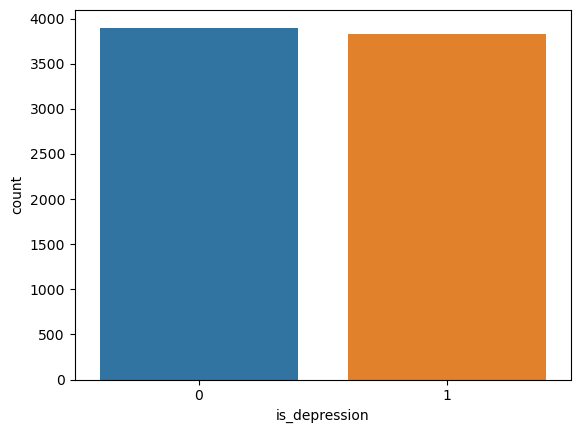

In [10]:
# this indicates that our dataset is pretty balanced
sns.countplot(data=df,x="is_depression")

#### Text transformation 
- tokenization, stemming, lemmatization

In [11]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [12]:
# lower case all words
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [13]:
def remove_non_alphabetic(text):
    return ''.join(char if char.isalpha() or char.isspace() else '' for char in text)

In [14]:
# remove non alphabetic characters
# wwe also see that the sentence has been stemmed, we only need to lemmatize it
df['clean_text'] = df['clean_text'].apply(remove_non_alphabetic)
df['clean_text'][3]

'i ve kind of stuffed around a lot in my life delaying the inevitable of having to work a job and be a responsible adult and i m but the longest i ve ever held a job wa  month it wasn t that i m lazy i wa always doing other thing i enjoy but i know now unemployment ha caused most of my depression recently i just feel utterly hopeless when i think soon enough i ll have to move out on my own in some shitty house working a job i couldn t care le about to me it just seems like the perfect recipe to depression'

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
# tokenize, lemmatize the text
text_lst = []
for i in df['clean_text']:
    tokens = word_tokenize(i)
    text = [lemmatizer.lemmatize(word) for word in tokens]
    text = " ".join(text)
    text_lst.append(text)

In [17]:
len(text_lst)

7731

In [18]:
text_lst[3]

'i ve kind of stuffed around a lot in my life delaying the inevitable of having to work a job and be a responsible adult and i m but the longest i ve ever held a job wa month it wasn t that i m lazy i wa always doing other thing i enjoy but i know now unemployment ha caused most of my depression recently i just feel utterly hopeless when i think soon enough i ll have to move out on my own in some shitty house working a job i couldn t care le about to me it just seems like the perfect recipe to depression'

#### Feature Engineering
- CountVectorizer
- TfidfVectorizer

*CountVectorizer*

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
vectorizer = CountVectorizer(min_df=10, max_df=0.8,ngram_range=(1,1),binary=False,stop_words='english')
X_CV = vectorizer.fit_transform(text_lst)

In [19]:
# check the feature matrix of the vectorized corpus
X_CV.shape

(7731, 2425)

In [26]:
# check the extracted features during the vectorization
feature_names = vectorizer.get_feature_names_out()
feature_names[:200]

array(['ab', 'abandoned', 'ability', 'able', 'absolute', 'absolutely',
       'abt', 'abuse', 'abused', 'abusive', 'academic', 'accept',
       'accepted', 'accepting', 'access', 'accident', 'accidentally',
       'accomplish', 'accomplished', 'account', 'ache', 'achieve',
       'achievement', 'acknowledge', 'act', 'acted', 'acting', 'action',
       'active', 'actively', 'activity', 'actual', 'actually', 'add',
       'added', 'addict', 'addicted', 'addiction', 'adding', 'adhd',
       'admit', 'admitted', 'adult', 'advance', 'advantage', 'advice',
       'af', 'affect', 'affected', 'affecting', 'afford', 'afraid',
       'afternoon', 'age', 'aggressive', 'ago', 'agree', 'agreed', 'ah',
       'ahead', 'ai', 'ain', 'air', 'airport', 'alarm', 'album',
       'alcohol', 'alcoholic', 'alive', 'allergy', 'allow', 'allowed',
       'alot', 'alright', 'amazing', 'ambition', 'american', 'amp',
       'anger', 'angry', 'animal', 'annoyed', 'annoying', 'answer',
       'anti', 'antidepressant

In [21]:
def get_topn_features(X, feature_names, topn=10):
    """
    Inputs:
        X: feature matrix
        feature_names: extracted features during vectorization
        topn: the number of most frequent features to return
    Outputs:
        topn most frequent features and their frequency
    """
    feature_ct = np.asarray(np.sum(X, axis=0)).reshape(-1)

    feature_freq = []
    
    for i in np.argsort(feature_ct)[::-1][:topn]:
        feature_freq.append({'feature':feature_names[i], 'frequency':feature_ct[i]})
    
    return pd.DataFrame(feature_freq)

In [22]:
get_topn_features(X_CV, feature_names, topn=20)

,feature,frequency
0,just,4527
1,wa,3810
2,like,3584
3,feel,3227
4,don,3029
5,want,2292
6,know,2283
7,life,2147
8,ve,2096
9,time,2070


In [23]:
# vectorize the corpus in order to use it in the model later
matrix_CV= vectorizer.fit_transform(text_lst).toarray() 

In [24]:
df_CV = pd.DataFrame(X_CV.toarray(), columns=vectorizer.get_feature_names_out())

*TfidfVectorizer*

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
vectorizer2 = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), min_df=10, max_df=0.8)

In [27]:
X_TF = vectorizer2.fit_transform(text_lst)
X_TF.shape

(7731, 1000)

In [28]:
vectorizer2.get_feature_names_out()

array(['able', 'absolutely', 'abuse', 'abusive', 'accept', 'accident',
       'account', 'act', 'action', 'actually', 'add', 'adhd', 'adult',
       'advice', 'affect', 'afford', 'afraid', 'age', 'ago', 'air',
       'alcohol', 'alive', 'allowed', 'alot', 'amazing', 'amp', 'anger',
       'angry', 'annoying', 'answer', 'antidepressant', 'anxiety',
       'anxious', 'anybody', 'anymore', 'anyways', 'apart', 'apartment',
       'apparently', 'appointment', 'appreciate', 'area', 'aren', 'arm',
       'ask', 'asked', 'asking', 'asleep', 'attack', 'attempt',
       'attempted', 'attention', 'avoid', 'awake', 'aware', 'away',
       'awful', 'awkward', 'baby', 'bad', 'badly', 'bar', 'barely',
       'basic', 'basically', 'bathroom', 'battle', 'bc', 'beat',
       'beautiful', 'bed', 'begin', 'beginning', 'believe', 'best',
       'better', 'big', 'biggest', 'bipolar', 'birthday', 'bit', 'black',
       'blame', 'blood', 'body', 'book', 'bored', 'boring', 'born', 'bos',
       'bother', 'boug

In [29]:
df_TF = pd.DataFrame(X_TF.toarray(), columns=vectorizer2.get_feature_names_out())
df_TF.head()

,able,absolutely,abuse,abusive,accept,accident,account,act,action,actually,...,wrong,wrote,www,yeah,year,yes,yesterday,young,younger,zoloft
0,0.040282,0.0,0.054669,0.0,0.057276,0.0,0.114553,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029501,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [30]:
# vectorize the corpus in order to use it in the model later
matrix2_TF= X_TF.toarray()

#### Decision Tree

In [31]:
# packages for machine learning 
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz 

# packages for plot and visualization
import matplotlib.pyplot as plt
from matplotlib import pylab
import graphviz 
pylab.rcParams["figure.figsize"] = (5.0, 4.0)
%matplotlib inline

### CountVectorizer Matrix 

In [32]:
#  Get the input feature matrix and target variable, prepare for model fitting
x1 = matrix_CV
y1 = df['is_depression']
x1.shape, y1.shape

((7731, 1000), (7731,))

In [33]:
y1.value_counts()

is_depression
0    3900
1    3831
Name: count, dtype: int64

In [34]:
# split the data into training and testing set
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=42)
x1_train.shape, x1_test.shape

((5411, 1000), (2320, 1000))

In [35]:
from sklearn.tree import DecisionTreeClassifier

In [36]:
# fit the decision tree model to the training data
dt_clf = DecisionTreeClassifier(random_state=42,criterion='entropy') 
dt_clf = dt_clf.fit(x1_train, y1_train)
np.round(dt_clf.score(x1_test,y1_test),3)

0.912

In [37]:
dt_clf.get_depth()

320

In [38]:
# manually tune the max_depth parameter, and find out the tree does not need 320 depth to fit the data
dt_clf = DecisionTreeClassifier(random_state=42,criterion='entropy',max_depth=30) 
dt_clf = dt_clf.fit(x1_train, y1_train)
np.round(dt_clf.score(x1_test,y1_test),3)

0.92

## Evaluation -DT

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [40]:
y1_true = y1
y1_pred = dt_clf.predict(x1) 
y1_true.shape, y1_pred.shape

((7731,), (7731,))

In [41]:
confusion_matrix(y1_true, y1_pred,labels=[0,1])

array([[3844,   56],
       [ 192, 3639]])

In [42]:
print(classification_report(y1_true, y1_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3900
           1       0.98      0.95      0.97      3831

    accuracy                           0.97      7731
   macro avg       0.97      0.97      0.97      7731
weighted avg       0.97      0.97      0.97      7731



In [43]:
accuracy_score(y1_true, y1_pred)

0.9679213555814254

In [44]:
y1_score = dt_clf.predict_proba(x1)[:, 1]

In [45]:
fpr, tpr, thresholds = roc_curve(y1_true, y1_score, pos_label=1)
roc_score = roc_auc_score(y1_true, y1_score)

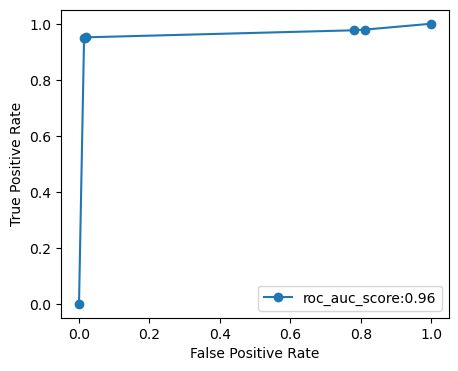

In [46]:
plt.plot(fpr,tpr,'o-',label="roc_auc_score:"+str(roc_score.round(2)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## Conclusion 1: from all of the evauation functions above, we can see that this model is performing really well. 

### TfidfVectorizer Matrix

In [47]:
x2 = matrix2_TF
y2 = df['is_depression']
x2.shape, y2.shape

((7731, 1000), (7731,))

In [48]:
# split the data into training and testing set
x2_train, x2_test, y2_train, y2_test = train_test_split(x1, y1, test_size=0.3, random_state=42)
x2_train.shape, x2_test.shape

((5411, 1000), (2320, 1000))

In [49]:
X_CV.toarray()

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
X_TF.toarray()

array([[0.04028175, 0.        , 0.05466921, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [51]:
# find the best max_depth for the decision tree model
for i in range(20,40):
    dt_clf_2 = DecisionTreeClassifier(random_state=42,criterion='entropy', max_depth=i) 
    dt_clf_2 = dt_clf_2.fit(x2_train, y2_train)
    score = np.round(dt_clf_2.score(x2_test,y2_test),3)
    print(i, score)

20 0.916
21 0.919
22 0.919
23 0.924
24 0.92
25 0.92
26 0.922
27 0.92
28 0.92
29 0.919
30 0.92
31 0.92
32 0.921
33 0.921
34 0.92
35 0.922
36 0.925
37 0.918
38 0.918
39 0.918


In [52]:
# fit the decision tree model with the best max_depth
dt_clf_2 = DecisionTreeClassifier(random_state=42,criterion='entropy', max_depth=36) 
dt_clf_2 = dt_clf_2.fit(x2_train, y2_train)
np.round(dt_clf_2.score(x2_test,y2_test),3)

0.925

## Evaluation-DT_tf

In [53]:
y2_true = y2
y2_pred = dt_clf_2.predict(x2)
confusion_matrix(y2_true, y2_pred,labels=[0,1]) 

array([[3889,   11],
       [3622,  209]])

In [54]:

print(classification_report(y2_true, y2_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      3900
           1       0.95      0.05      0.10      3831

    accuracy                           0.53      7731
   macro avg       0.73      0.53      0.39      7731
weighted avg       0.73      0.53      0.39      7731



In [55]:
accuracy_score(y2_true, y2_pred)

0.5300737291424137

In [56]:
y2_score = dt_clf_2.predict_proba(x2)[:, 1]

In [57]:
fpr, tpr, thresholds = roc_curve(y2_true, y2_score, pos_label=1)
roc_score = roc_auc_score(y2_true, y2_score)

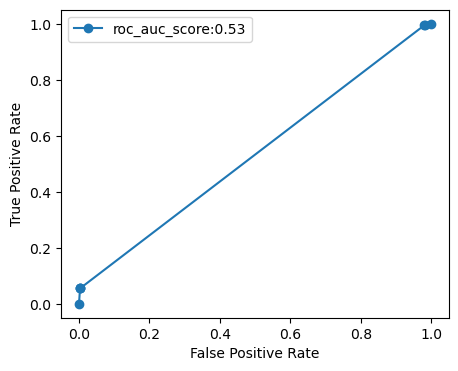

In [58]:
plt.plot(fpr,tpr,'o-',label="roc_auc_score:"+str(roc_score.round(2)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## Conclusion 2: Suprisingly, although the tfidf vectorizors'model have really similar model performance score(0.925) as the countvectorizer model performance score(0.92), all the other evaluation matrix are showing that the model is performing randomly, I think the ROC can represent this conclusion the most straightforwardly. 

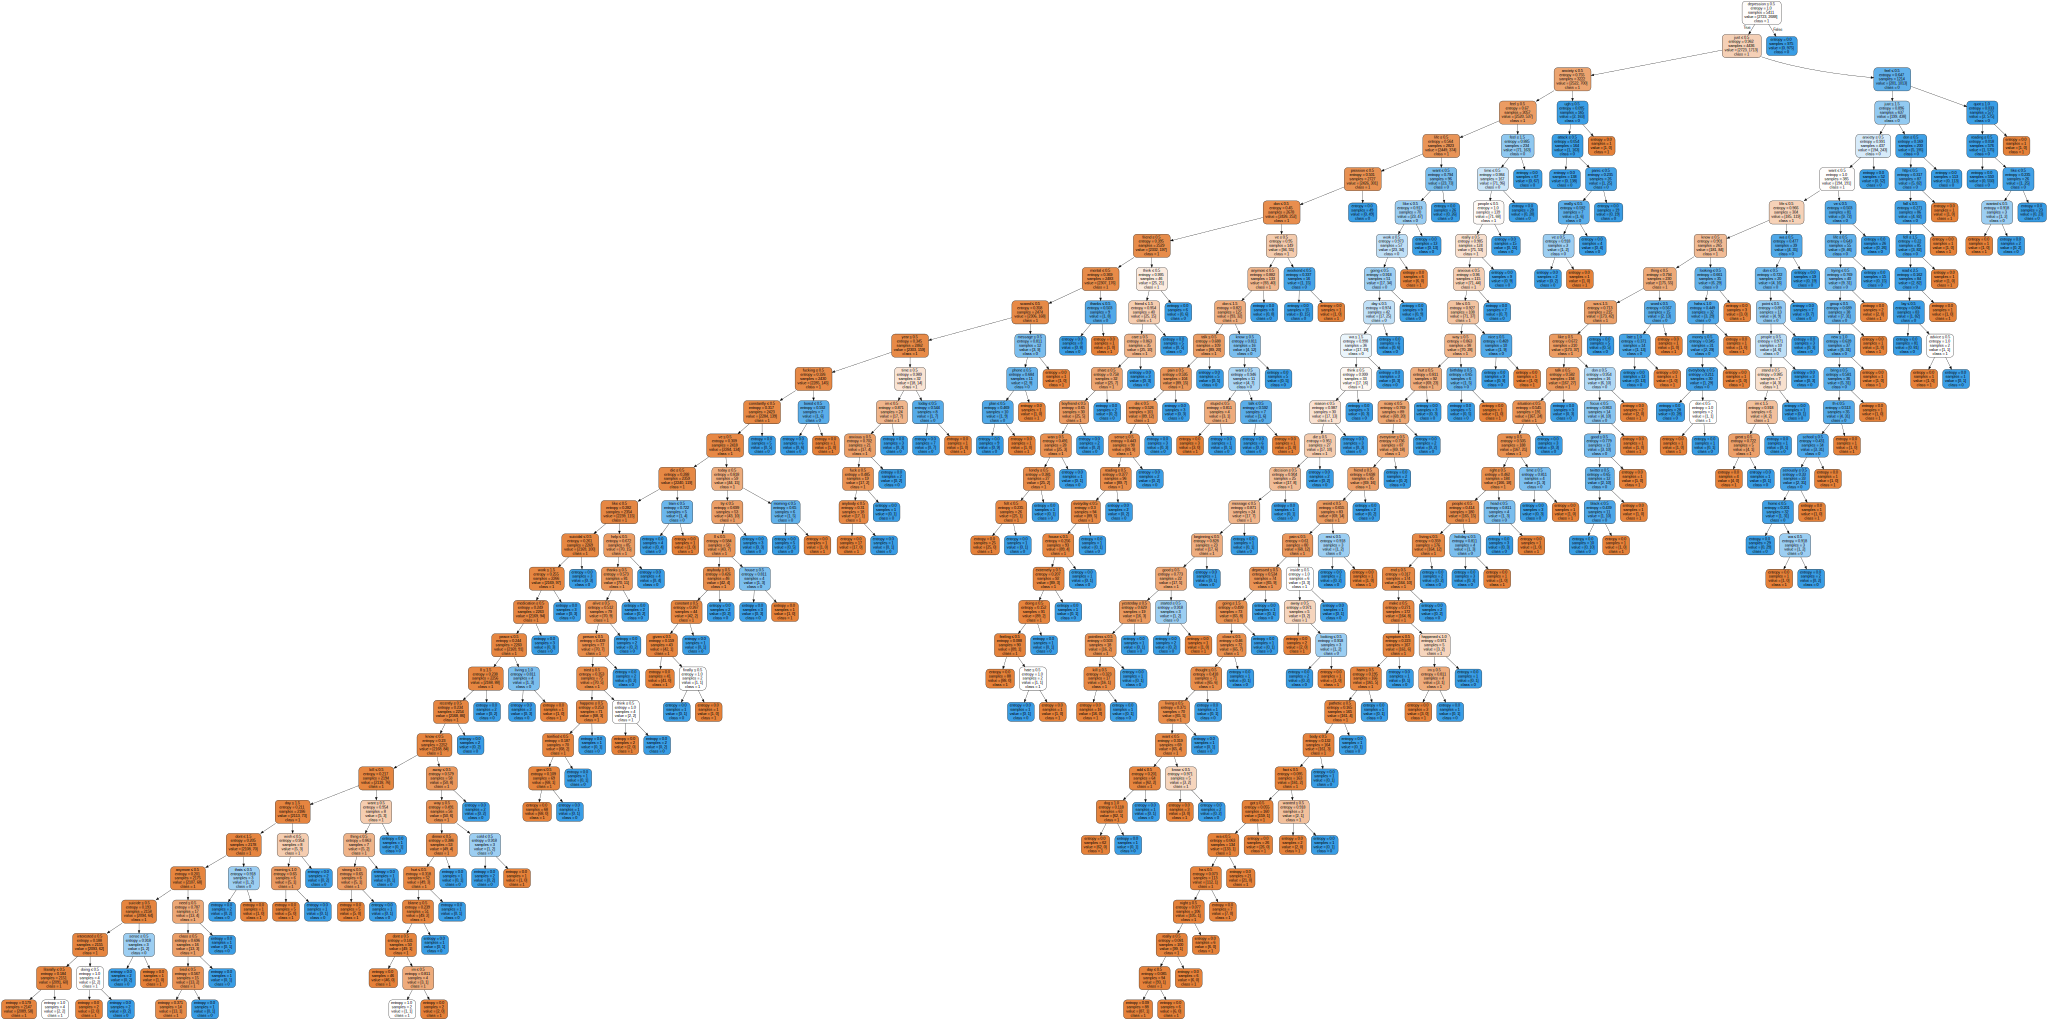

In [59]:
#  Visualize the fitted DecisionTreeClassifier for the CountVectorizer

dot_data_cv = tree.export_graphviz(dt_clf, out_file=None, 
                                feature_names= df_CV.columns.tolist(), 
                                class_names= df["is_depression"].unique().astype(str),  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph_cv = graphviz.Source(dot_data_cv)  
graph_cv

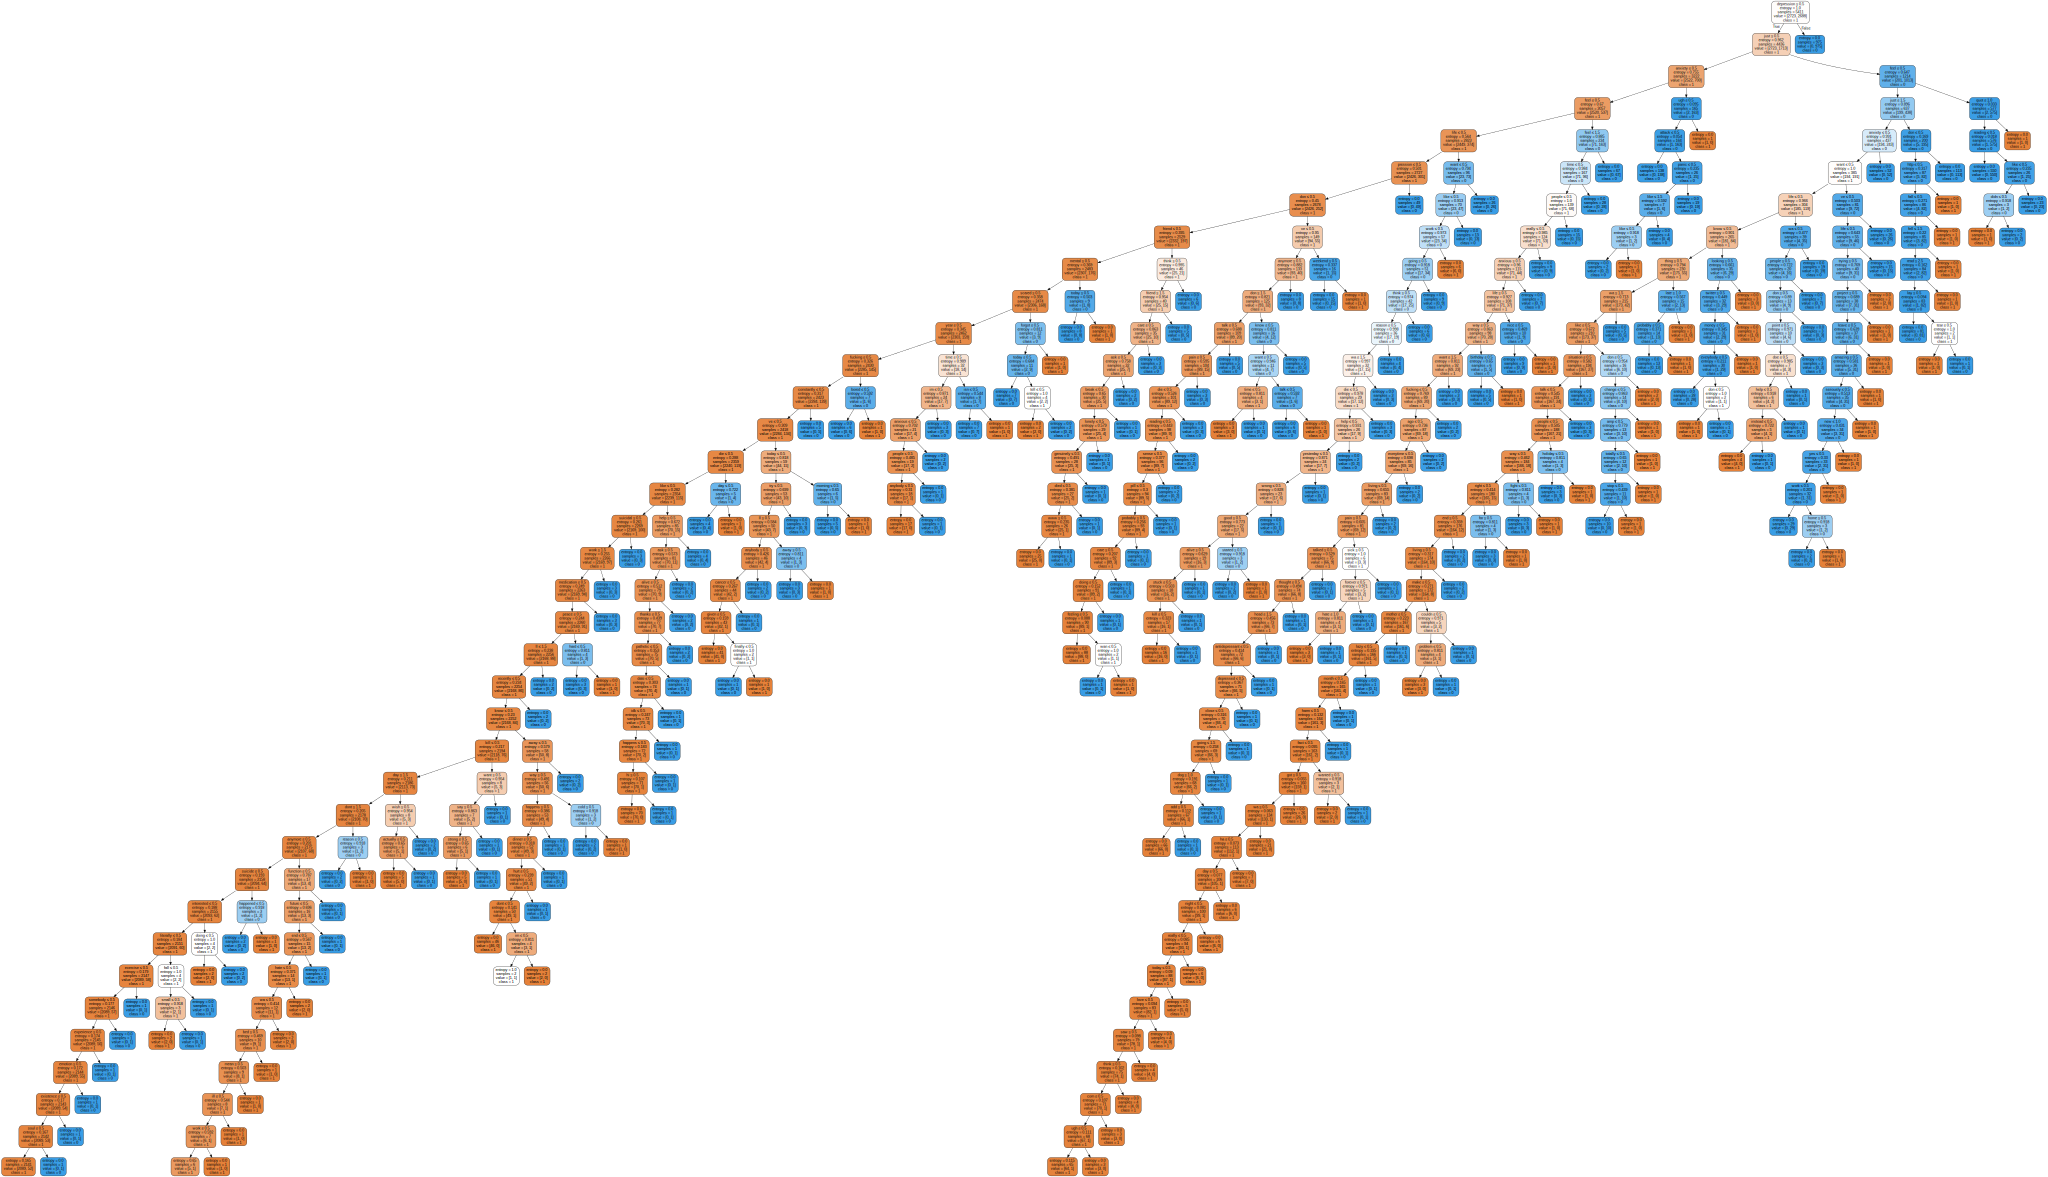

In [60]:
#  Visualize the fitted DecisionTreeClassifier for TF-IDF vectorized corpus

dot_data_tf = tree.export_graphviz(dt_clf_2, out_file=None, 
                                feature_names= df_TF.columns.tolist(), 
                                class_names= df["is_depression"].unique().astype(str),  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data_tf)  
graph 

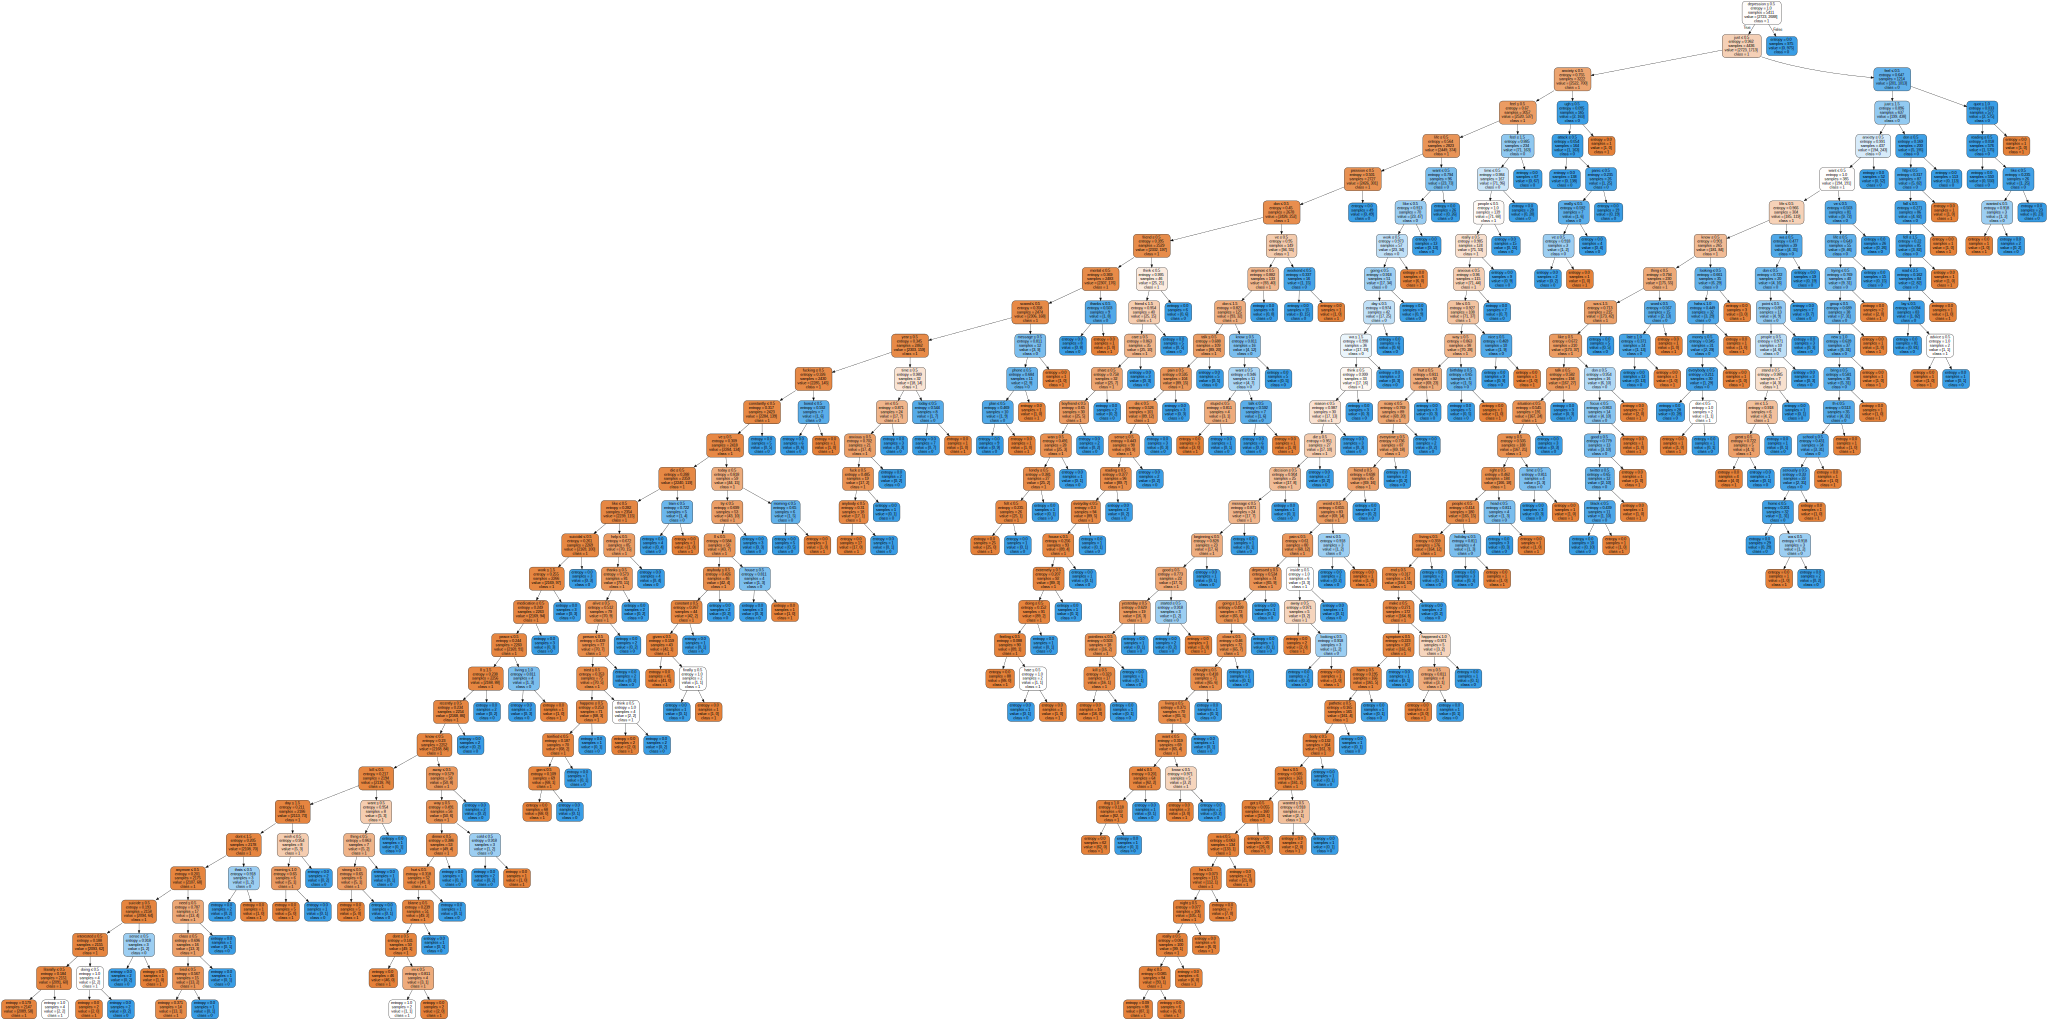

In [61]:
#  Visualize the fitted DecisionTreeClassifier for the CountVectorizer

dot_data_cv = tree.export_graphviz(dt_clf, out_file=None, 
                                feature_names= df_CV.columns.tolist(), 
                                class_names= df["is_depression"].unique().astype(str),  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph_cv = graphviz.Source(dot_data_cv)  
graph_cv

### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
# build a random forest classifier for the count vectorized feature matrix
rf_clf = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=42)
rf_clf = rf_clf.fit(x1_train, y1_train)
np.round(rf_clf.score(x1_test,y1_test),3)

0.946

In [64]:
y1_true = y1
y1_pred = rf_clf.predict(x1) 
confusion_matrix(y1_true, y1_pred,labels=[0,1])

array([[3874,   26],
       [ 113, 3718]])

In [65]:
accuracy_score(y1_true, y1_pred)

0.9820204372008796

In [66]:
# build a random forest classifier for the TF-IDF vectorized feature matrix
rf_clf2 = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=42)
rf_clf2 = rf_clf2.fit(x2_train, y2_train)
np.round(rf_clf2.score(x2_test,y2_test),3)

0.946

In [67]:
y2_true = y2
y2_pred = rf_clf2.predict(x2) 
confusion_matrix(y2_true, y2_pred,labels=[0,1])

array([[3886,   14],
       [3617,  214]])

## Conclusion 3: From these sets of evaluation above, I think countvectorizor is performing a lot better than Tfidfvectorizor. This is a really useful conclusion for me because from the model performance score I generated before, model trained by either of the vectorizor normally perform really similarly. I was never able to figure out which model is better, and I kept doing double validation. However, after using the evaluation methods we learned last week, I can tell directly yhat countervectorizor is better than Tf so far! It's not super surprising that random forest can improve the performance but I am happy to see that CV_RF is able to generate 98% accuracy score. Maybe that will be my final model, who knows lol

## Logistic regression

- CV

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
# fit the logistic regression model without any regularization
lg_None = LogisticRegression(random_state=0, solver='liblinear',).fit(x1_train, y1_train)
score1 = np.round(lg_None.score(x1_test, y1_test), 3)
score1

0.956

## Evaluation_Logistic Regression_CV

In [70]:
y1_true = y1
y1_pred = lg_None.predict(x1) 
confusion_matrix(y1_true, y1_pred,labels=[0,1])

array([[3874,   26],
       [ 184, 3647]])

In [71]:
print(classification_report(y1_true, y1_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3900
           1       0.99      0.95      0.97      3831

    accuracy                           0.97      7731
   macro avg       0.97      0.97      0.97      7731
weighted avg       0.97      0.97      0.97      7731



In [72]:
accuracy_score(y1_true, y1_pred)

0.972836631742336

In [73]:
y1_score = lg_None.predict_proba(x1)[:, 1]
fpr, tpr, thresholds = roc_curve(y1_true, y1_score, pos_label=1)
roc_score = roc_auc_score(y1_true, y1_score)

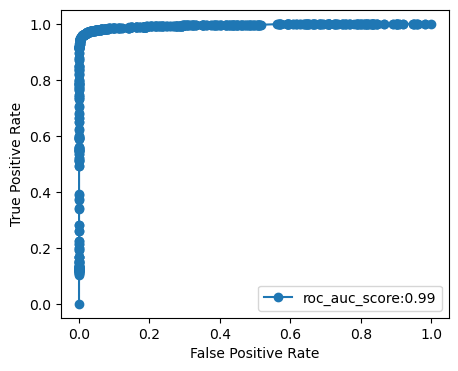

In [74]:
plt.plot(fpr,tpr,'o-',label="roc_auc_score:"+str(roc_score.round(2)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## Evaluation_logistic regression_TF

In [75]:
lg_tf_None = LogisticRegression(random_state=0, solver='liblinear',).fit(x2_train, y2_train)
score2 = np.round(lg_tf_None.score(x2_test, y2_test), 3)
score2

0.956

In [76]:
y2_true = y2
y2_pred = lg_tf_None.predict(x2) 
confusion_matrix(y2_true, y2_pred,labels=[0,1])

array([[3900,    0],
       [3542,  289]])

## Conclusion 4: I didn't continue the evaluation process for the tfidf vectorizor logistic regression model because the confusion matrix result and previous tf models have shown that it wouldn't perform better than count vectorizer. Therefore, I think I will continue this project with countvectorizer matrix. This is a really helpful piece of information. Moreover, other than that, CV_dandom forest perform the best among all these models for far and I will use gridsearchcv to further refine my model. 

## Gridsearchcv

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [78]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression()),
    ]
)

In [79]:
parameters = {
    "vect__max_df": (0.5, 0.75, 1.0),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "tfidf__use_idf": (True, False),
    "clf__penalty": ['l1', 'l2'],
    "clf__C": [0.1, 1, 10],
}

In [80]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [81]:
grid_search.fit(text_lst, y1)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Best score: 0.961
Best parameters set:
	clf__C: 10
	clf__penalty: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


## Conclusion 5: this gridsearch confirmed our previous thought that countvectorizer would perform better in this case. Moreover, the vect_max_df and vect_ngram_range indicates that we need to fine tuning our countvectorizer in order to generate the best outcome. 

## K-fold Validation: 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score

In [ ]:
#adope the best parameters to the logistic regression model
vectorizer_best = CountVectorizer(min_df=10, max_df=0.5,ngram_range=(1,2),binary=False,stop_words='english',max_features=1000)
X_best = vectorizer_best.fit_transform(text_lst).toarray()

In [ ]:
y_best = df['is_depression']

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
clf = LogisticRegression(random_state=42,solver='liblinear',penalty='l2',C=10)
cv_scores = cross_val_score(clf, X_best, y_best, cv=kf, scoring='recall')
cv_scores

array([0.93062827, 0.94401042, 0.93552632, 0.94458763, 0.92791612])

### Summary

## This project check provides lots of meaningful results and I learned some new things. 
- First of all, I will only need to train model based on countvectorizer because it always perform better and the conlusion has been proved by the gridsearch. 
- Also, after performing the gridsearch by myself. I learned two most important things that I didn't catch up in class. For the pipline, it looks like I can only use one modle. For example, after using Logisstic regression, I can't include random forest and decision tree in it. Moreover, I didn't know that I can use the grid search to vectorize the vectorizors. That is so cool! 
- the current best performance model is the ranom forest, and then it would be the optimized logistic regression model after applying gridsearch. 
- the k-fold cross validation indicates that the parameters found by gridsearch does perform pretty well. The average score is able 0.93, which means our model is working well. 